# Morphological filters

When working with masks, one can use another class of filters, that just turn pixels ON and OFF depending on their surroundings. The simplest to understand are the erosion and dilation filters. As their name indicate, these filters either shrink or enlarge ON objects. The size and shape of the filters, specify what region is considered around objects to shrink or enlarge them. We use here again the ```footprint``` argument to specify such structuring elements.

Here we import one of the Atlas images, take a crop of it and then create a mask with the Otsu method:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from microfilm.microplot import microshow
import skimage
import skimage.io
import skimage.morphology

image_stack = skimage.io.imread('../data/IMG_6499.jpg')

image_plant = image_stack[1450:1900,500:1000,1]

image_noisy = skimage.util.random_noise(image_plant, mode='s&p')

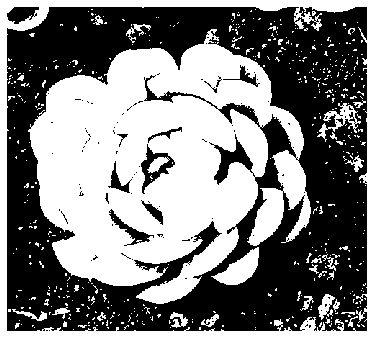

In [2]:
mask = image_plant > skimage.filters.threshold_otsu(image_plant)

microshow(mask, fig_scaling=5);

We can just specify the influence region as a Numpy array. For example a square of size 5:

In [3]:
influence_region = np.ones((5,5))

and then erode the white regions in the image above using that square: any white pixel that is within the footprint centered on a black pixel is turned black:

In [4]:
eroded = skimage.morphology.binary_erosion(mask, footprint=influence_region)

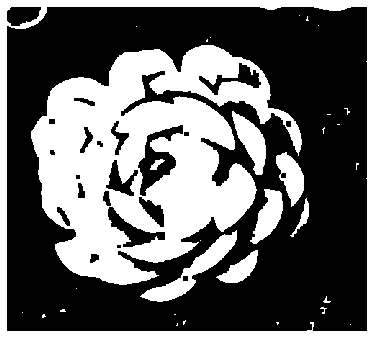

In [5]:
microshow(eroded, fig_scaling=5);

We can erode even more:

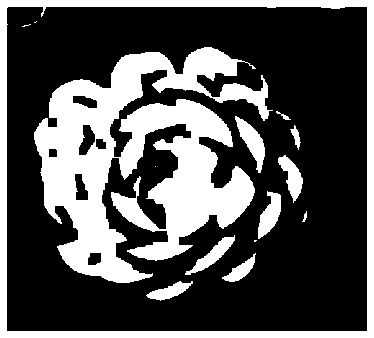

In [6]:
influence_region = np.ones((10,10))

eroded = skimage.morphology.binary_erosion(mask, footprint=influence_region)

microshow(eroded, fig_scaling=5);

We can do the reseverse an dilate our image:

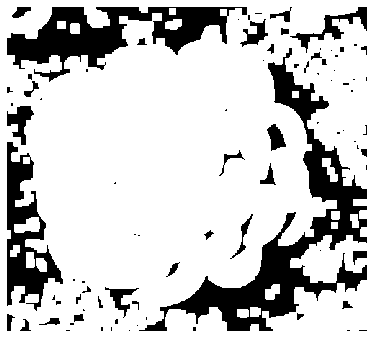

In [7]:
influence_region = np.ones((10,10))

dilated = skimage.morphology.binary_dilation(mask, footprint=influence_region)

microshow(dilated, fig_scaling=5);

## Image clean-up

How are these operators useful in image processing ? Let's again imagine that we have a noisy image. Our mask would look like this:

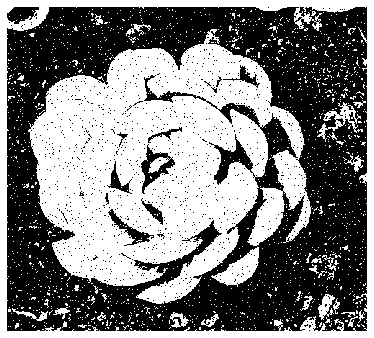

In [8]:
mask = image_noisy > skimage.filters.threshold_otsu(image_noisy)

microshow(mask, fig_scaling=5);

We can now fill the little holes in the nuclei with a small dilation:

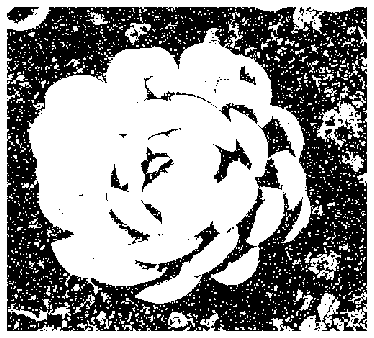

In [9]:
influence_region = np.ones((2,2))

step1 = skimage.morphology.binary_dilation(mask, footprint=influence_region)

microshow(step1, fig_scaling=5);

And erode again to put the nuclei back to their original size:

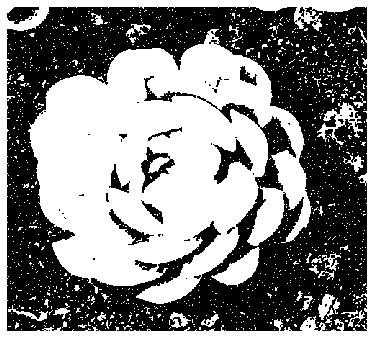

In [10]:
influence_region = np.ones((2,2))

step2 = skimage.morphology.binary_erosion(step1, footprint=influence_region)

microshow(step2, fig_scaling=5);

We still have some noise. So we can do another round where we first erode the image (to remove dust) and dilate it again to recover nuclei of correct size:

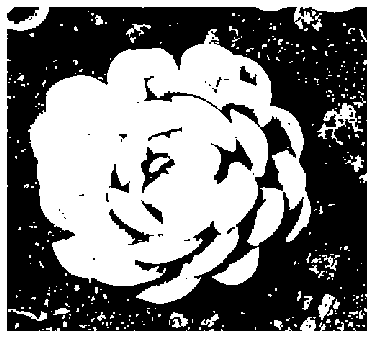

In [11]:
influence_region = np.ones((2,2))

step3 = skimage.morphology.binary_erosion(step2, footprint=influence_region)
step4 = skimage.morphology.binary_dilation(step3, footprint=influence_region)

microshow(step4, fig_scaling=5);

## Opening, closing

The combination of erosion and dilation is defined as specific operators (opening, closing) and are widely used. For example we can simply reproduce the result above by using ```binary_opening``` which is an erosion followed by a dilation:

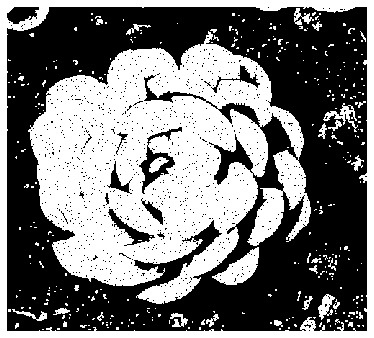

In [12]:
influence_region = np.ones((2,2))

microshow(skimage.morphology.binary_opening(mask, footprint=influence_region),
          fig_scaling=5);

## Other operators

Other morphological operators exist. For example one can shrink as much as possible all the structures of the image using the ```skeletonize``` function:


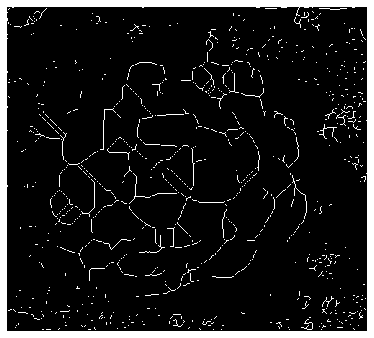

In [13]:
skeleton = skimage.morphology.skeletonize(step4)

microshow(skeleton, fig_scaling=5);

Additionally, you can find many other tools for flood filling, removing holes, finding maxima etc. in this module. We leave it up to the reader to explore the documentation.

## Other packages

You can of course find useful functions in other packages. An example of this we can *fill holes* that we have in our nuclei with a function from the scipy package:

In [14]:
import scipy.ndimage as ndi

In [15]:
image_closed = skimage.morphology.binary_closing(mask, footprint=influence_region)

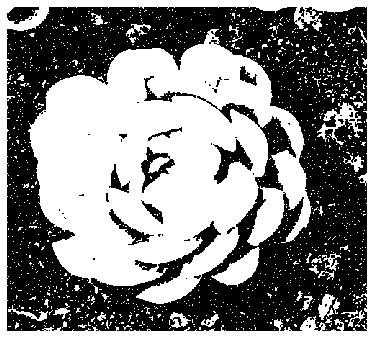

In [16]:
microshow(image_closed, fig_scaling=5);

In [17]:
image_fill = ndi.binary_fill_holes(image_closed, skimage.morphology.disk(5))

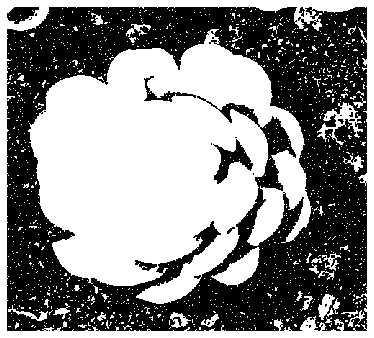

In [18]:
microshow(image_fill, fig_scaling=5);

## Application

We are going to need these morphological operators for a very specific operation in our small workflow. Let's look at two images from our dataset:

In [26]:
image1 = skimage.io.imread('../data/cellatlas/24138_196_F7_2.tiff')
image2 = skimage.io.imread('../data/cellatlas/27897_273_C8_2.tiff')

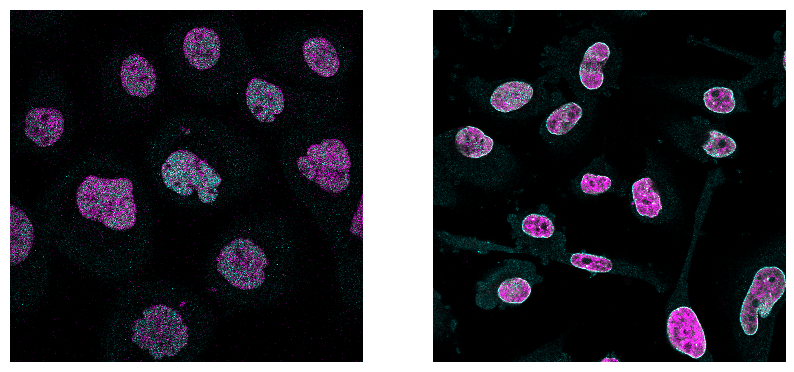

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
microshow(np.moveaxis(image1, 2,0)[1:3], ax=ax[0])
microshow(np.moveaxis(image2, 2,0)[1:3], ax=ax[1]);

The signal we are interested in is shown in cyan above. In some cases it is located in the whole nucleus and in other cases it is only located in the nucleus membrane. Therefore what we really want to measure is somehow the ratio between the nucleus internal and "border" signal.

Let's produce again a nucleus segmentation by first applying a median filter, then automatically thresholding the image:

In [28]:
image_nuclei = image1[:,:,2]

# filter image
image_nuclei = skimage.filters.median(image_nuclei, skimage.morphology.disk(5))

# create mask and clean-up
mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
mask_nuclei = skimage.morphology.binary_closing(mask_nuclei, footprint=skimage.morphology.disk(5))
mask_nuclei = ndi.binary_fill_holes(mask_nuclei, skimage.morphology.disk(5))

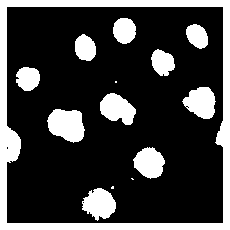

In [29]:
microshow(mask_nuclei);

### Creating a border

One way to create a border is to shrink the objects in the mask by erosion and then use those small nuclei to mask the inner part of the label image.

First, erosion of the mask:

In [30]:
mask_nuclei_eroded = skimage.morphology.binary_erosion(mask_nuclei, skimage.morphology.disk(10))

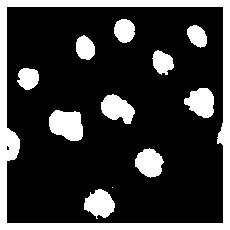

In [31]:
microshow(mask_nuclei_eroded);

Now we use this to mask the original objects. Once we keep only the inner part and once only the outer part by inverting the above mask:

In [32]:
labels_masked_inner = mask_nuclei * mask_nuclei_eroded
labels_masked_outer = mask_nuclei * (1-mask_nuclei_eroded)

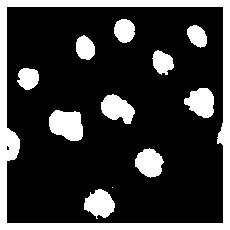

In [33]:
microshow(labels_masked_inner);

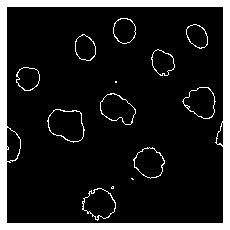

In [34]:
microshow(labels_masked_outer);

## Exercise

1. Continue with the cloud data of 02-Threshold: ```landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band4_crop.tif```
2. Create a mask using the Li method
3. Apply an erosion and then a dilation, both with the footprint of a disk of radius 20
4. Compare the initial mask with the one obtained in 3 e.g. by plotting them as multi-channel image. What do you observe?